In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
plot_dir = "../../../results/plots/"
COORDINATES = ["chrom", "pos", "ref", "alt"]

In [3]:
data_path = "gnomad/merged/all"
model_path = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"
V = (
    pl.read_parquet(f"../../../results/{data_path}/test.parquet", columns=COORDINATES + ["AF"])
    .with_columns(pl.read_parquet(f"../../../results/preds/results/{data_path}/{model_path}.parquet", columns="score")["score"])
    .unique(subset=["chrom", "pos"], keep="none")
    .with_columns(
        pl.when(pl.col("AF") <= 0.5).then(pl.col("AF")).otherwise(1 - pl.col("AF")).alias("MAF"),
        pl.when(pl.col("AF") <= 0.5).then(pl.col("score")).otherwise(-pl.col("score")),
    )
)
V

chrom,pos,ref,alt,AF,score,MAF
str,i64,str,str,f64,f32,f64
"""1""",10111,"""C""","""A""",0.000023,-0.017578,0.000023
"""1""",10131,"""C""","""A""",0.000009,-0.347656,0.000009
"""1""",10132,"""T""","""C""",0.000263,0.884766,0.000263
"""1""",10139,"""A""","""T""",0.000017,-0.432617,0.000017
"""1""",10140,"""A""","""C""",0.000028,0.074219,0.000028
"""1""",10141,"""C""","""G""",0.00002,-0.496094,0.00002
"""1""",10145,"""A""","""T""",0.000177,-0.43457,0.000177
"""1""",10147,"""C""","""G""",0.004386,-0.486328,0.004386
"""1""",10149,"""C""","""A""",0.000059,-0.246094,0.000059


In [4]:
breaks = np.arange(-15.5, 12.5)
bins = breaks + 0.5

V = V.with_columns(
    (pl.col("score").cut(breaks, include_breaks=True).struct.field("brk") - 0.5).alias("score_bin")
).filter(pl.col("score_bin").is_in(bins))

In [5]:
df = (
    V.group_by("score_bin")
    .agg(pl.mean("MAF").alias("MAF-mean"), pl.count("MAF").alias("MAF-count"))
    .sort("score_bin")
    .to_pandas()
)
df

,score_bin,MAF-mean,MAF-count
0,-14.0,0.000009,76
1,-13.0,0.000061,11143
2,-12.0,0.000040,63281
3,-11.0,0.000081,155347
4,-10.0,0.000147,265247
5,-9.0,0.000236,431772
6,-8.0,0.000444,756581
7,-7.0,0.000794,1538679
8,-6.0,0.001151,3788514
9,-5.0,0.001504,9146503


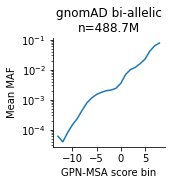

In [6]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)


plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=df[df["MAF-count"] >= 1000],
    x="score_bin",
    y="MAF-mean",
    errorbar=None,
)
plt.xlabel("GPN-MSA score bin")
plt.ylabel("Mean MAF")
title = f"gnomAD bi-allelic\nn={format_number(len(V))}"
plt.title(title)
sns.despine();
g.set(yscale='log');
plt.xticks([-10, -5, 0, 5]);
#plt.savefig(plot_dir + "gnomad_full_score_vs_maf.svg", bbox_inches="tight")